<a href="https://colab.research.google.com/github/Nacho2904/orga_de_datos/blob/main/tp3_parte_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from google.colab import drive 
import nltk
import functools
import xgboost as xgb

drive.mount('/content/gdrive')
path_a_training_set = 'gdrive/MyDrive/TP3 dataset music/train.parquet'
path_a_test_set = 'gdrive/MyDrive/TP3 dataset music/test.parquet'


df_music_train = pd.read_parquet(path_a_training_set).fillna("")
df_music_test = pd.read_parquet(path_a_test_set).fillna("")

Mounted at /content/gdrive


## Preprocessing

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

genres = list(df_music_train["genre"].unique())
def get_vectorizers_by_genre(df_music: pd.DataFrame) -> dict:
  df_music_lyric_tokenized = df_music.copy().fillna("")
  df_music_lyric_tokenized["lyric"] = df_music_lyric_tokenized["lyric"].map(lambda lyric: set(nltk.word_tokenize(lyric)))
  df_music_grouped_by_genre = df_music_lyric_tokenized[["genre", "lyric"]].groupby('genre').agg(lambda x: functools.reduce(set.union, x)).reset_index()
  vocabs = dict(zip(df_music_grouped_by_genre.genre.to_list(), df_music_grouped_by_genre.lyric.to_list()))
  stopwords = set(nltk.corpus.stopwords.words("english")).union(set(nltk.corpus.stopwords.words("spanish"))).union(set(nltk.corpus.stopwords.words("french")))
  vectorizers = {genre: TfidfVectorizer(input = "content", stop_words = stopwords, vocabulary = vocabs[genre]) for genre in genres}
  for genre in genres:
    vectorizers[genre].fit(df_music[df_music["genre"] == genre]["genre"])
  return vectorizers

vectorizers = get_vectorizers_by_genre(df_music_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [3]:
def get_sum_tfidf_from_lyrics(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music = df_music.fillna("")
  column_names = ["sum_tfidf_for_" + genre.lower() for genre in genres]
  for i in range(0, len(genres)):
    df_music[column_names[i]] = np.sum(vectorizers[genres[i]].transform(df_music["lyric"]), axis = 1)
  return df_music[column_names]

get_sum_tfidf_from_lyrics(df_music_train).columns

Index(['sum_tfidf_for_dance', 'sum_tfidf_for_pop', 'sum_tfidf_for_r&b',
       'sum_tfidf_for_hip-hop', 'sum_tfidf_for_rap', 'sum_tfidf_for_soul',
       'sum_tfidf_for_rock', 'sum_tfidf_for_blues', 'sum_tfidf_for_folk',
       'sum_tfidf_for_jazz', 'sum_tfidf_for_country',
       'sum_tfidf_for_alternative', 'sum_tfidf_for_children’s music',
       'sum_tfidf_for_indie', 'sum_tfidf_for_electronic',
       'sum_tfidf_for_classical', 'sum_tfidf_for_opera', 'sum_tfidf_for_world',
       'sum_tfidf_for_ska', 'sum_tfidf_for_comedy', 'sum_tfidf_for_reggae',
       'sum_tfidf_for_reggaeton', 'sum_tfidf_for_children's music',
       'sum_tfidf_for_soundtrack', 'sum_tfidf_for_anime',
       'sum_tfidf_for_movie'],
      dtype='object')

In [4]:
def eliminate_genres_without_enough_observations(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music_recuento_filas_por_genero = df_music.groupby("genre").count().reset_index()[["genre", "track_name"]].rename(
    columns = {"track_name": "rowCount"}).sort_values("rowCount")
  problematic_genres = list(df_music_recuento_filas_por_genero[df_music_recuento_filas_por_genero["rowCount"] < 50].genre)[1:]
  return df_music[~df_music["genre"].isin(problematic_genres)]

In [5]:
nltk.download('punkt')
def get_length_transforms_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["number_of_lines"] = df_music["lyric"].map(lambda lyric: len(lyric.split("\n")))
  df_music["number_of_tokens"] = df_music["lyric"].map(lambda lyric: len(nltk.word_tokenize(lyric)))
  df_music["length_lyrics"] = df_music["lyric"].map(lambda lyric: len(lyric))
  return df_music[["length_lyrics", "number_of_lines", "number_of_tokens"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
nltk.download('averaged_perceptron_tagger')

def get_POS_vector_from_lyric_POS(lyric_POS):
  useful_pos_tags = ["FW", "JJR", "NN", "NNS", "NNP", "PDT", "PRP", "RB", "RBR",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]
  POS_dictionary = {pos_tag:0 for pos_tag in useful_pos_tags}
  POS_dictionary.update({"other":0})

  for token in lyric_POS:
    if token[1] in useful_pos_tags:
      POS_dictionary[token[1]] += 1
    else:
      POS_dictionary["other"] += 1

  return [POS_dictionary[pos_tag] for pos_tag in POS_dictionary]
  

def get_POS_chunk_taggin_counts_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["lyric_POS"] = df_music["lyric"].map(lambda lyric: nltk.pos_tag(nltk.word_tokenize(lyric)))
  df_music["lyric_POS"] = df_music["lyric_POS"].map(lambda lyric_pos: get_POS_vector_from_lyric_POS(lyric_pos))
  return pd.DataFrame(df_music["lyric_POS"].to_list())


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
df_music_filtered_genres = eliminate_genres_without_enough_observations(df_music_train)
artists = list(df_music_filtered_genres["artist"].unique())
train_artists = set(artists[:int(0.9*len(artists))])
validation_artists = set(artists[int(0.9*len(artists)):])
train_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(train_artists)]
validation_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(validation_artists)]

In [8]:
def mean_hot_encoder(df_music: pd.DataFrame, df_training: pd.DataFrame) -> pd.DataFrame:
  df_training_grouped_by_lang = df_training.groupby("language").mean().reset_index()[["language", "popularity"]]
  df_new_columns = df_music.merge(df_training_grouped_by_lang, on = "language", how = "left")
  return df_new_columns[["popularity_y"]].fillna(0)

mean_hot_encoder_using_training_set = lambda df_to_encode: mean_hot_encoder(df_to_encode, df_music_train) 

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

text_features = ["track_name", "lyric", "artist"]

numerical_features = ["a_songs", "a_popularity", "popularity", "acousticness", "danceability", "duration_ms",
                   "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]

ordinal_features = ["key"]

one_hot_features = ["mode"]

mean_enc_features = ["language"]

artist_genres = ["a_genres", "genre"]

label = ["genre"]

identity_transformer = preprocessing.FunctionTransformer(None)

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df_music_train["genre"])

full_processor = ColumnTransformer(transformers=[
    ('text_tf_idf', preprocessing.FunctionTransformer(get_sum_tfidf_from_lyrics), text_features),
    ('text_simple_transforms', preprocessing.FunctionTransformer(get_length_transforms_for_text), text_features),
    ('text_POS_count', preprocessing.FunctionTransformer(get_POS_chunk_taggin_counts_for_text), text_features),
    ('mean_encoding', preprocessing.FunctionTransformer(mean_hot_encoder_using_training_set), list(df_music_train.columns)),
    ('one_hot_encoding', preprocessing.OneHotEncoder(), one_hot_features),
    ('numerical', identity_transformer, numerical_features),
    ('ordinal', preprocessing.OrdinalEncoder(categories = [['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']]), ordinal_features)])

logistic_regression_pipeline = Pipeline(steps = [
    ('preprocess_X', full_processor),
    ('model', LogisticRegression(penalty='l2', C = 1, solver = "liblinear", max_iter = 500, fit_intercept = True))
])


## XGBoost

In [10]:
X_train = full_processor.fit_transform(train_set)
y_train = label_encoder.transform(train_set.genre)
X_validation = full_processor.transform(validation_set)
y_validation = label_encoder.transform(validation_set.genre)

In [19]:
modelo_xgb = xgb.XGBClassifier(enable_categorical = True, booster = "gbtree")
modelo_xgb.fit(X_train, y_train)

XGBClassifier(enable_categorical=True, objective='multi:softprob')

In [22]:
preds = modelo_xgb.predict_proba(X_validation)
top_k_accuracy_score(y_validation, preds, labels = modelo_xgb.classes_), accuracy_score(y_validation, modelo_xgb.predict(X_validation))

(0.5312090790048014, 0.33347883020515057)

In [46]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import expon
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from scipy.stats import poisson

space={'max_depth': hp.quniform("max_depth", 3, 30, 1),
        'gamma': hp.uniform ('gamma', 1,6),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 100, 1),
        'n_estimators': hp.uniform("n_estimators", 50, 350),
        'seed': 0}

def objective(space):

  evaluation = [( X_train, y_train), ( X_validation, y_validation)]

  classifier = xgb.XGBClassifier(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                                  min_child_weight=space['min_child_weight'],
                                  colsample_bytree=space['colsample_bytree'], objective = "multi:softprob", booster = "gbtree",
                                  enable_categorical = True)
  
  classifier.fit(X_train, y_train, verbose=False, early_stopping_rounds = 8,
                 eval_set=evaluation, eval_metric="mlogloss")

  preds = classifier.predict_proba(X_validation)
  accuracy = top_k_accuracy_score(y_validation, preds, labels = classifier.classes_)
  
  print ("top_k_accuracy_score:", accuracy)
  print(classifier.get_params())

  return {'loss': -accuracy, 'status': STATUS_OK }
  
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

top_k_accuracy_score:
0.522479266695766
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5219968644856546, 'gamma': 4.921466938643114, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 22, 'min_child_weight': 5.0, 'missing': None, 'n_estimators': 221, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'enable_categorical': True}
top_k_accuracy_score:
0.5443037974683544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.3275686765123345, 'gamma': 1.1166725262933839, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 20.0, 'missing': None, 'n_estimators': 110, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1

In [47]:
import pickle
pickle.dump(trials, open("myfile.p", "wb"))

In [48]:
best_hyperparams

{'colsample_bytree': 0.3275686765123345,
 'gamma': 1.1166725262933839,
 'max_depth': 8.0,
 'min_child_weight': 20.0,
 'n_estimators': 110.322111802987}

In [49]:
modelo_xgb = xgb.XGBClassifier(n_estimators =int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']),
                               gamma = best_hyperparams['gamma'], min_child_weight=best_hyperparams['min_child_weight'],
                               colsample_bytree=best_hyperparams['colsample_bytree'], objective = "multi:softprob",
                               booster = "gbtree", enable_categorical = True)

modelo_xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.3275686765123345, enable_categorical=True,
              gamma=1.1166725262933839, max_depth=8, min_child_weight=20.0,
              n_estimators=110, objective='multi:softprob')

In [50]:
preds = modelo_xgb.predict_proba(X_validation)
top_k_accuracy_score(y_validation, preds, labels = modelo_xgb.classes_), accuracy_score(y_validation, modelo_xgb.predict(X_validation))

(0.5434308162374509, 0.34177215189873417)

In [64]:
modelo_xgb.save_model("XGBClassificator.json")

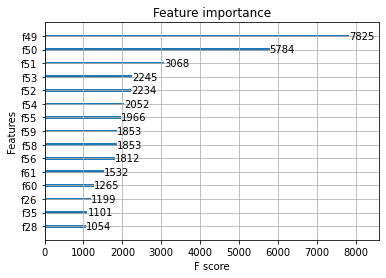

In [91]:
xgb.plot_importance(modelo_xgb,  max_num_features=15)

In [88]:
columns =['sum_tfidf_for_dance', 'sum_tfidf_for_pop', 'sum_tfidf_for_r&b',
       'sum_tfidf_for_hip-hop', 'sum_tfidf_for_rap', 'sum_tfidf_for_soul',
       'sum_tfidf_for_rock', 'sum_tfidf_for_blues', 'sum_tfidf_for_folk',
       'sum_tfidf_for_jazz', 'sum_tfidf_for_country',
       'sum_tfidf_for_alternative', 'sum_tfidf_for_children’s music',
       'sum_tfidf_for_indie', 'sum_tfidf_for_electronic',
       'sum_tfidf_for_classical', 'sum_tfidf_for_opera', 'sum_tfidf_for_world',
       'sum_tfidf_for_ska', 'sum_tfidf_for_comedy', 'sum_tfidf_for_reggae',
       'sum_tfidf_for_reggaeton', "sum_tfidf_for_children's music",
       'sum_tfidf_for_soundtrack', 'sum_tfidf_for_anime',
       'sum_tfidf_for_movie'] + \
                  ["length_lyrics", "number_of_lines", "number_of_tokens"] + \
                  ["FW", "JJR", "NN", "NNS", "NNP", "PDT", "PRP", "RB", "RBR",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"] + \
                  ["Minus", "Major"] + \
                  ["popularity_by_lang", "loudness_by_lang"] + numerical_features + ordinal_features


In [90]:
columns[50:60]

['a_popularity',
 'popularity',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness']

Vemos que las features más importantes àra el XGBoost son las features numéricas originales.